In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
import numpy as np
import pandas as pd
from torchmetrics.classification import BinaryAccuracy

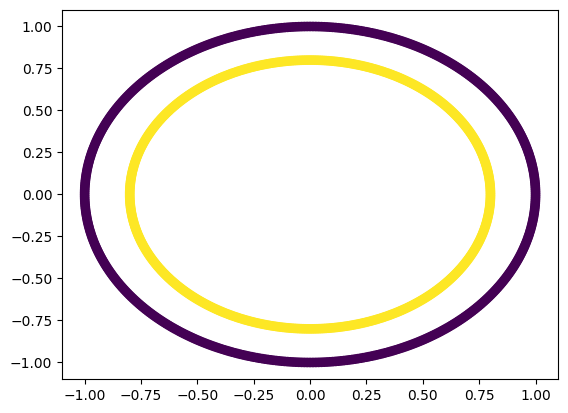

In [48]:
#Create a dataset
x,y = make_circles(1000,random_state=42)
data = pd.DataFrame({
    "x1" : x[:,0],
    "x2" : x[:,1],
    "y" : y,
})

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

device = "cuda" if torch.cuda.is_available() else "cpu"

plt.scatter(
    x = x[:,0],
    y = x[:,1],
    c=y
)

In [49]:
class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=2,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=1),
            nn.Sigmoid(),
        )

    def forward(self,x : torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [50]:
#Train test split and device agnostic

train_len = int(0.8*len(x))

x_train,x_test = x[:train_len], x[train_len:]
y_train,y_test = y[:train_len], y[train_len:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [51]:
"""def accuracy(y_true,y_preds):
    x = torch.eq(y_true,y_preds).sum().item()
    return (x/len(y_true))*100"""
accuracy = BinaryAccuracy()

In [43]:
#Train Loop

model_0 = BinaryClassificationModel().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(params=model_0.parameters(),lr=1e-1)

x_train,x_test = x_train.to(device), x_test.to(device)
y_train,y_test = y_train.to(device), y_test.to(device)

epochs = 10000
for epoch in range(epochs):
    model_0.train()
    train_logits = model_0(x_train).squeeze()
    train_preds = torch.round(train_logits)
    loss = loss_fn(train_logits,y_train)
    acc = accuracy(y_train,train_preds).item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()


    if epoch%100 == 0:
        model_0.eval()
        test_logits = model_0(x_test).squeeze()
        test_preds = torch.round(test_logits)
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy(y_test,test_preds).item()

        print(f"Epoch : {epoch} | Train loss : {loss:.5f} | Train acc : {acc:.2f} | Test loss : {test_loss:.5f} | Test acc : {test_acc:.2f}")


Epoch : 0 | Train loss : 0.72542 | Train acc : 0.50 | Test loss : 0.72812 | Test acc : 0.50
Epoch : 100 | Train loss : 0.71375 | Train acc : 0.50 | Test loss : 0.71648 | Test acc : 0.50
Epoch : 200 | Train loss : 0.70532 | Train acc : 0.50 | Test loss : 0.70819 | Test acc : 0.50
Epoch : 300 | Train loss : 0.69993 | Train acc : 0.50 | Test loss : 0.70284 | Test acc : 0.50
Epoch : 400 | Train loss : 0.69670 | Train acc : 0.50 | Test loss : 0.69960 | Test acc : 0.50
Epoch : 500 | Train loss : 0.69482 | Train acc : 0.50 | Test loss : 0.69766 | Test acc : 0.50
Epoch : 600 | Train loss : 0.69370 | Train acc : 0.50 | Test loss : 0.69645 | Test acc : 0.50
Epoch : 700 | Train loss : 0.69299 | Train acc : 0.50 | Test loss : 0.69566 | Test acc : 0.50
Epoch : 800 | Train loss : 0.69252 | Train acc : 0.50 | Test loss : 0.69511 | Test acc : 0.50
Epoch : 900 | Train loss : 0.69218 | Train acc : 0.50 | Test loss : 0.69471 | Test acc : 0.50
Epoch : 1000 | Train loss : 0.69194 | Train acc : 0.50 | Test 

In [44]:
model_0.eval()
trained_logits = model_0(x_test).squeeze()
torch.eq(y_test,torch.round(trained_logits)).sum().item()

200

In [45]:
#Test on a new dataset

x1,y1 = make_circles(1000,noise=0.03)
x1,y1 = torch.from_numpy(x1).type(torch.float), torch.from_numpy(y1).type(torch.float)

x1_train,x1_test = x1[:train_len].to(device), x1[train_len:].to(device)
y1_train,y1_test = y1[:train_len].to(device), y1[train_len:].to(device)

y_preds = torch.round((model_0(x1_train).squeeze()))
torch.eq(y1_train,y_preds).sum().item()

800

In [46]:
a,b = make_moons(1000)

a,b =  torch.from_numpy(a).to(device).type(torch.float), torch.from_numpy(b).to(device).type(torch.float)

a_train,a_test = a[:train_len], a[train_len:]
b_train, b_test = b[:train_len], b[train_len:]

moon_preds = torch.round(model_0(a_train).squeeze())
torch.eq(b_train,moon_preds).sum().item() / len(b_train)

0.72